In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR,SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,Lasso
from sklearn.metrics import r2_score,mean_absolute_error, accuracy_score,confusion_matrix

In [4]:
df=pd.read_excel('Telco_customer_churn.xlsx')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [5]:
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [6]:
df.shape

(7043, 33)

In [7]:
df['Total Charges'] = df['Total Charges'].astype(str).str.replace(',', '', regex=False)
df['Total Charges']=pd.to_numeric(df['Total Charges'],errors='coerce')
df['Total Charges']=df['Total Charges'].fillna(0)
df['Total Charges']=df['Total Charges'].astype('int64')
print(df['Total Charges'].dtypes)

int64


In [8]:
df['Average Monthly Spend'] = df['Total Charges']/df['Tenure Months']

internet=['Online Security','Online Backup','Device Protection','Tech Support']
streaming=['Streaming TV','Streaming Movies']

df['Number of Internet Features']=0
df['Number of Streaming Features']=0

for i in df.index:
    count = 0
    for col in internet:
        if df.at[i,col] == 'Yes':
            count += 1
    df.at[i, 'Number of Internet Features']=count

for i in df.index:
    count = 0
    for col in streaming:
        if df.at[i,col] == 'Yes':
            count += 1
    df.at[i, 'Number of Streaming Features']=count

print('Unique Number of Internet Feature :',df['Number of Internet Features'].unique())
print('Unique Number of Streaming Features :', df['Number of Streaming Features'].unique())


Unique Number of Internet Feature : [2 0 1 3 4]
Unique Number of Streaming Features : [0 2 1]


In [9]:
contract=df.groupby(['Contract'],observed=True,as_index=False)['Count'].count()
contract

,Contract,Count
0,Month-to-month,3875
1,One year,1473
2,Two year,1695


In [10]:
# Groupby churn Reason

reason_for_churn=df.groupby(['Churn Reason'],observed=True,as_index=False)['Count'].count()
reason_for_churn

,Churn Reason,Count
0,Attitude of service provider,135
1,Attitude of support person,192
2,Competitor had better devices,130
3,Competitor made better offer,140
4,Competitor offered higher download speeds,189
5,Competitor offered more data,162
6,Deceased,6
7,Don't know,154
8,Extra data charges,57
9,Lack of affordable download/upload speed,44


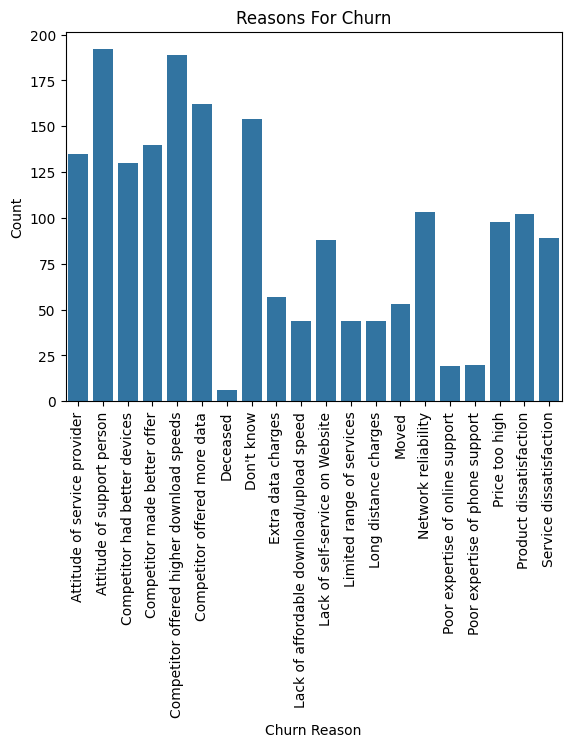

In [11]:
sns.barplot(data=reason_for_churn,x='Churn Reason',y='Count')
plt.title('Reasons For Churn')
plt.xticks(rotation=90)
plt.show()

In [12]:
df['Churn Score'].unique()

array([ 86,  67,  84,  89,  78, 100,  92,  77,  97,  74,  66,  65,  70,
        90,  82,  69,  81,  96,  87,  88,  75,  76,  95,  99,  80,  73,
        94,  83,  98,  71,  85,  68,  91,  93,  72,  79,  27,  61,  43,
        51,  58,  39,  35,  57,  53,  21,  38,  40,  41,  22,  25,  64,
        49,  62,  52,  59,  29,  33,  20,  30,  26,  54,  56,  55,  28,
        37,   9,  60,  24,  63,  23,  47,  32,   8,  46,  42,  48,  36,
        34,   7,  50,  44,  31,   5,  45])

In [13]:
df['Churn_score_cut']=pd.qcut(df['Churn Score'],10)
gender_churn=pd.crosstab(index=df['Churn_score_cut'],columns=[df['Gender']])
gender_churn


Gender,Female,Male
Churn_score_cut,,
"(4.999, 28.0]",402,381
"(28.0, 36.0]",299,339
"(36.0, 45.0]",388,371
"(45.0, 53.0]",334,345
"(53.0, 61.0]",324,362
"(61.0, 68.0]",392,407
"(68.0, 73.0]",341,350
"(73.0, 78.0]",345,336
"(78.0, 87.0]",328,344


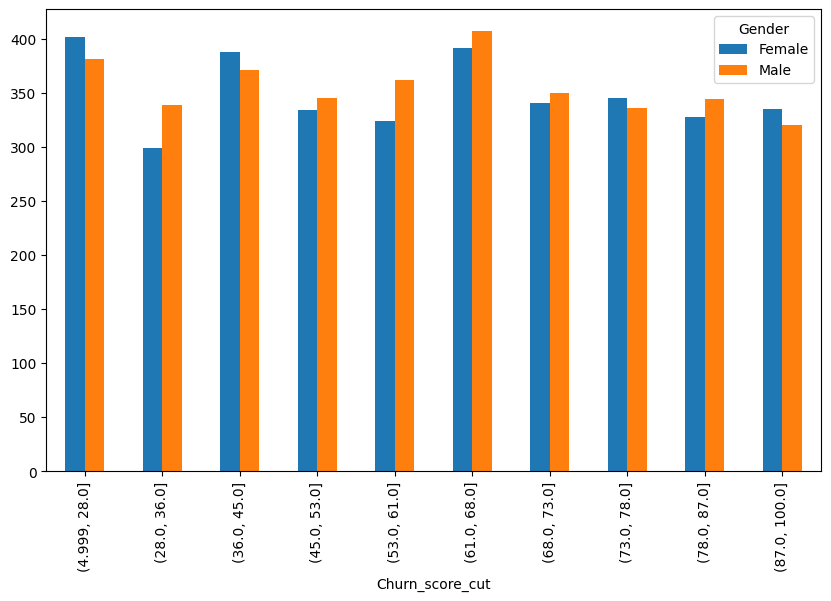

In [14]:
gender_churn.plot(kind='bar',figsize=(10,6))
plt.xticks(rotation=90)
plt.show()

In [15]:
np.sort(df['CLTV'].unique())

array([2003, 2004, 2006, ..., 6495, 6499, 6500], shape=(3438,))

In [16]:
df['total_monthly_charges_cut']=pd.qcut(df['CLTV'],20)
total_charges_churn=df.groupby(['total_monthly_charges_cut'],observed=True,as_index=False)['Churn Score'].count()
total_charges_churn

,total_monthly_charges_cut,Churn Score
0,"(2002.999, 2296.0]",354
1,"(2296.0, 2611.2]",351
2,"(2611.2, 2895.3]",352
3,"(2895.3, 3175.4]",352
4,"(3175.4, 3469.0]",354
5,"(3469.0, 3766.0]",351
6,"(3766.0, 4042.0]",352
7,"(4042.0, 4194.0]",352
8,"(4194.0, 4369.0]",353
9,"(4369.0, 4527.0]",351


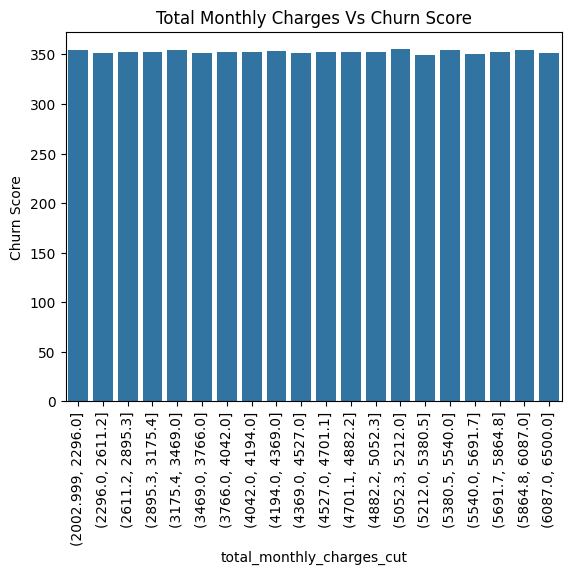

In [17]:
sns.barplot(data=total_charges_churn,x='total_monthly_charges_cut',y='Churn Score')
plt.title('Total Monthly Charges Vs Churn Score')
plt.xticks(rotation=90)
plt.show()

In [18]:
print(df.shape)

(7043, 38)


In [19]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason,Average Monthly Spend,Number of Internet Features,Number of Streaming Features,Churn_score_cut,total_monthly_charges_cut
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Yes,1,86,3239,Competitor made better offer,54.000000,2,0,"(78.0, 87.0]","(3175.4, 3469.0]"
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Yes,1,67,2701,Moved,75.500000,0,0,"(61.0, 68.0]","(2611.2, 2895.3]"
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,1,86,5372,Moved,102.500000,1,2,"(78.0, 87.0]","(5212.0, 5380.5]"
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,1,84,5003,Moved,108.785714,2,2,"(78.0, 87.0]","(4882.2, 5052.3]"
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,1,89,5340,Competitor had better devices,102.775510,2,2,"(87.0, 100.0]","(5212.0, 5380.5]"


In [20]:
df.drop(columns=internet + streaming)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason,Average Monthly Spend,Number of Internet Features,Number of Streaming Features,Churn_score_cut,total_monthly_charges_cut
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Yes,1,86,3239,Competitor made better offer,54.000000,2,0,"(78.0, 87.0]","(3175.4, 3469.0]"
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Yes,1,67,2701,Moved,75.500000,0,0,"(61.0, 68.0]","(2611.2, 2895.3]"
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,1,86,5372,Moved,102.500000,1,2,"(78.0, 87.0]","(5212.0, 5380.5]"
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,1,84,5003,Moved,108.785714,2,2,"(78.0, 87.0]","(4882.2, 5052.3]"
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,1,89,5340,Competitor had better devices,102.775510,2,2,"(87.0, 100.0]","(5212.0, 5380.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,No,0,45,5306,NaN,19.708333,0,0,"(36.0, 45.0]","(5212.0, 5380.5]"
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,No,0,59,2140,NaN,82.916667,3,2,"(53.0, 61.0]","(2002.999, 2296.0]"
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,No,0,71,5560,NaN,102.250000,2,2,"(68.0, 73.0]","(5540.0, 5691.7]"
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,No,0,59,2793,NaN,31.454545,1,0,"(53.0, 61.0]","(2611.2, 2895.3]"


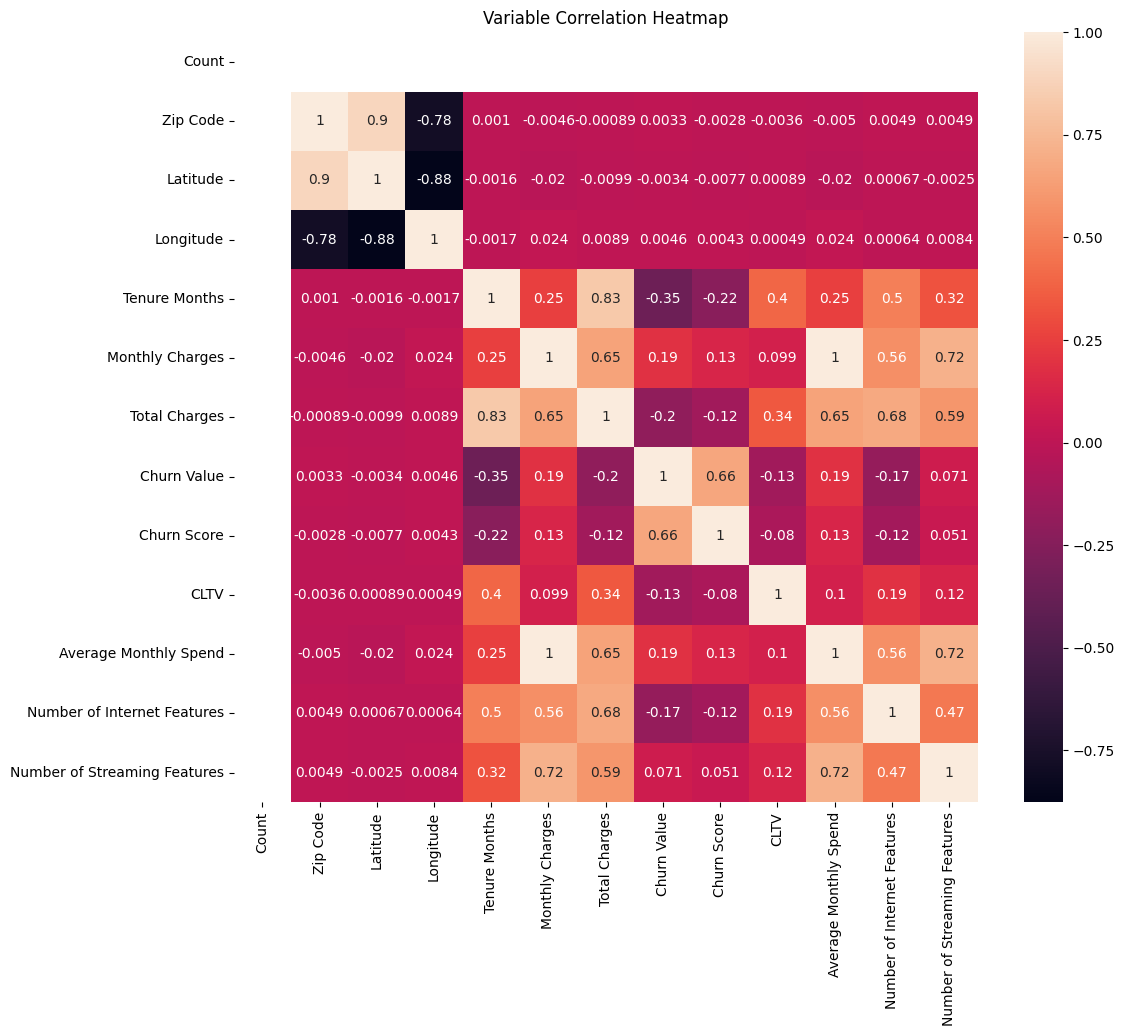

In [21]:
plt.figure(figsize=(12,10))
corr=df.corr(numeric_only=True)
sns.heatmap(corr,annot=True)
plt.title('Variable Correlation Heatmap')
plt.show()

In [22]:
df = df.drop(columns=['CustomerID','Count','Country','State','City','Zip Code','Lat Long','Latitude','Longitude','Churn Label','Churn Value','Churn Reason','Monthly Charges','Tenure Months'])

In [23]:
df.head()

,Gender,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,...,Paperless Billing,Payment Method,Total Charges,Churn Score,CLTV,Average Monthly Spend,Number of Internet Features,Number of Streaming Features,Churn_score_cut,total_monthly_charges_cut
0,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,...,Yes,Mailed check,108,86,3239,54.000000,2,0,"(78.0, 87.0]","(3175.4, 3469.0]"
1,Female,No,No,Yes,Yes,No,Fiber optic,No,No,No,...,Yes,Electronic check,151,67,2701,75.500000,0,0,"(61.0, 68.0]","(2611.2, 2895.3]"
2,Female,No,No,Yes,Yes,Yes,Fiber optic,No,No,Yes,...,Yes,Electronic check,820,86,5372,102.500000,1,2,"(78.0, 87.0]","(5212.0, 5380.5]"
3,Female,No,Yes,Yes,Yes,Yes,Fiber optic,No,No,Yes,...,Yes,Electronic check,3046,84,5003,108.785714,2,2,"(78.0, 87.0]","(4882.2, 5052.3]"
4,Male,No,No,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,...,Yes,Bank transfer (automatic),5036,89,5340,102.775510,2,2,"(87.0, 100.0]","(5212.0, 5380.5]"


In [24]:
binary_map={
    'Yes':1,
    'No':0,
    'No internet service':0,
    'No phone service':0
}

binary_cols=['Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
    'Paperless Billing', 'Multiple Lines', 'Online Security',
    'Online Backup', 'Device Protection', 'Tech Support',
    'Streaming TV', 'Streaming Movies']

for col in binary_cols:
    df[col]=df[col].map(binary_map)

df.columns
df.dropna()

,Gender,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,...,Paperless Billing,Payment Method,Total Charges,Churn Score,CLTV,Average Monthly Spend,Number of Internet Features,Number of Streaming Features,Churn_score_cut,total_monthly_charges_cut
0,Male,0,0,0,1,0,DSL,1,1,0,...,1,Mailed check,108,86,3239,54.000000,2,0,"(78.0, 87.0]","(3175.4, 3469.0]"
1,Female,0,0,1,1,0,Fiber optic,0,0,0,...,1,Electronic check,151,67,2701,75.500000,0,0,"(61.0, 68.0]","(2611.2, 2895.3]"
2,Female,0,0,1,1,1,Fiber optic,0,0,1,...,1,Electronic check,820,86,5372,102.500000,1,2,"(78.0, 87.0]","(5212.0, 5380.5]"
3,Female,0,1,1,1,1,Fiber optic,0,0,1,...,1,Electronic check,3046,84,5003,108.785714,2,2,"(78.0, 87.0]","(4882.2, 5052.3]"
4,Male,0,0,1,1,1,Fiber optic,0,1,1,...,1,Bank transfer (automatic),5036,89,5340,102.775510,2,2,"(87.0, 100.0]","(5212.0, 5380.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,0,0,1,0,No,0,0,0,...,1,Bank transfer (automatic),1419,45,5306,19.708333,0,0,"(36.0, 45.0]","(5212.0, 5380.5]"
7039,Male,0,1,1,1,1,DSL,1,0,1,...,1,Mailed check,1990,59,2140,82.916667,3,2,"(53.0, 61.0]","(2002.999, 2296.0]"
7040,Female,0,1,1,1,1,Fiber optic,0,1,1,...,1,Credit card (automatic),7362,71,5560,102.250000,2,2,"(68.0, 73.0]","(5540.0, 5691.7]"
7041,Female,0,1,1,0,0,DSL,1,0,0,...,1,Electronic check,346,59,2793,31.454545,1,0,"(53.0, 61.0]","(2611.2, 2895.3]"


In [25]:
df.dtypes

Gender                            object
Senior Citizen                     int64
Partner                            int64
Dependents                         int64
Phone Service                      int64
Multiple Lines                     int64
Internet Service                  object
Online Security                    int64
Online Backup                      int64
Device Protection                  int64
Tech Support                       int64
Streaming TV                       int64
Streaming Movies                   int64
Contract                          object
Paperless Billing                  int64
Payment Method                    object
Total Charges                      int64
Churn Score                        int64
CLTV                               int64
Average Monthly Spend            float64
Number of Internet Features        int64
Number of Streaming Features       int64
Churn_score_cut                 category
total_monthly_charges_cut       category
dtype: object

In [26]:
df.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Total Charges', 'Churn Score', 'CLTV', 'Average Monthly Spend',
       'Number of Internet Features', 'Number of Streaming Features',
       'Churn_score_cut', 'total_monthly_charges_cut'],
      dtype='object')

In [27]:
x=df[['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Contract', 'Paperless Billing', 'Payment Method',
       'Total Charges', 'CLTV', 'Average Monthly Spend',
       'Number of Internet Features', 'Number of Streaming Features']]

y=df['Churn Score']

# x=x.dropna()
# y=y.loc[x.index]

# df.shape

In [28]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Contract', 'Paperless Billing',
       'Payment Method', 'Total Charges', 'CLTV', 'Average Monthly Spend',
       'Number of Internet Features', 'Number of Streaming Features'],
      dtype='object')

In [29]:
cat_cols=['Gender','Internet Service','Contract','Payment Method']
num_cols=['Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Paperless Billing',
 'Total Charges',
 'CLTV',
 'Average Monthly Spend',
 'Number of Internet Features',
 'Number of Streaming Features']

In [30]:
colsCat=[]
for col in x_train.columns:
    if x_train[col].dtype == 'int64' or x_train[col].dtype == 'float64':
        colsCat.append(col)

colsCat



['Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Paperless Billing',
 'Total Charges',
 'CLTV',
 'Average Monthly Spend',
 'Number of Internet Features',
 'Number of Streaming Features']

In [31]:
one_hot=OneHotEncoder(sparse_output=False,handle_unknown='ignore')
scaler=StandardScaler()

LINEAR REGRESSION

In [32]:
preprocessor=ColumnTransformer(transformers=[
    ('Categorical Pipeline',Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('one_hot',one_hot)
    ]), cat_cols),
    ('Numerical Pipeline',Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('Scaler',scaler)
    ]),num_cols)
])
preprocessor

,transformers,"[('Categorical Pipeline', ...), ('Numerical Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [33]:
x_train.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Contract', 'Paperless Billing',
       'Payment Method', 'Total Charges', 'CLTV', 'Average Monthly Spend',
       'Number of Internet Features', 'Number of Streaming Features'],
      dtype='object')

In [34]:
preprocessor.fit_transform(x_train,x_test)

array([[ 0.        ,  1.        ,  0.        , ...,  1.11212923,
        -0.2073701 ,  1.4452877 ],
       [ 1.        ,  0.        ,  0.        , ...,  1.12059132,
         0.56892436,  0.27164243],
       [ 1.        ,  0.        ,  0.        , ...,  1.39931685,
         0.56892436,  1.4452877 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -1.45422407,
        -0.98366457, -0.90200285],
       [ 0.        ,  1.        ,  0.        , ..., -1.49848485,
        -0.98366457, -0.90200285],
       [ 0.        ,  1.        ,  0.        , ...,  1.14010544,
         0.56892436,  1.4452877 ]], shape=(5634, 23))

In [35]:
pipeline_linear=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',LinearRegression())
])
pipeline_linear

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Categorical Pipeline', ...), ('Numerical Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
pipeline_linear.fit(x_train,y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Categorical Pipeline', ...), ('Numerical Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
y_pred=pipeline_linear.predict(x_test)
y_pred

array([66.56856289, 61.25289819, 57.69315077, ..., 69.18212438,
       50.98509435, 70.73981981], shape=(1409,))

In [38]:
print(r2_score(y_test,y_pred))

0.12163206383976566


RANDOM FOREST

In [39]:
pipeline_rf=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',RandomForestRegressor())
])
pipeline_rf

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Categorical Pipeline', ...), ('Numerical Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
pipeline_rf.fit(x_train,y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Categorical Pipeline', ...), ('Numerical Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
y_pred_rf=pipeline_rf.predict(x_test)
print(r2_score(y_test,y_pred_rf))

0.05678639727554724


LOGISTIC

In [42]:
pipeline_logistic=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',LogisticRegression())
])
pipeline_logistic

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Categorical Pipeline', ...), ('Numerical Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [43]:
pipeline_logistic.fit(x_train,y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Categorical Pipeline', ...), ('Numerical Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
y_pred_logistic=pipeline_rf.predict(x_test)


In [45]:
print(r2_score(y_test,y_pred_logistic))

0.05678639727554724


LASSO 

In [46]:
pipeline_lasso=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('Model', Lasso())
])
pipeline_lasso

,steps,"[('preprocessor', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Categorical Pipeline', ...), ('Numerical Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [47]:
pipeline_lasso.fit(x_train,y_train)

,steps,"[('preprocessor', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Categorical Pipeline', ...), ('Numerical Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [48]:
lasso_pred=pipeline_lasso.predict(x_test)
print(r2_score(y_test,lasso_pred))

0.10603267305332464


RIDGE

In [49]:
pipeline_ridge=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('Model', Ridge())
])
pipeline_ridge

,steps,"[('preprocessor', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Categorical Pipeline', ...), ('Numerical Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [50]:
pipeline_ridge.fit(x_train,y_train)

,steps,"[('preprocessor', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Categorical Pipeline', ...), ('Numerical Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [51]:
ridge_pred=pipeline_ridge.predict(x_test)
print(r2_score(y_test,ridge_pred))

0.12162923525593339


SVR

for classification